# Process Features for Model Training
This notebook processes and combines GPS and IMU data for feature extraction. It aligns GPS (1 Hz) with IMU sensor data (50 Hz) and extracts features such as acceleration, angular velocity, and orientation.

Step 1: Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

Step 2: Load Data

Load GPS and IMU data and explain their contents.

In [2]:
# Load GPS data
gps_data = pd.read_csv('../data-collection/2024-12-10_22-37-46_Data/labeled_position_data.csv')
gps_data['Timestamp'] = pd.to_datetime(gps_data['Timestamp'])
print(gps_data.head())
# Load IMU data
acceleration_data = pd.read_csv('../data-collection/2024-12-10_22-37-46_Data/acceleration_data.csv')

angular_velocity_data = pd.read_csv('../data-collection/2024-12-10_22-37-46_Data/angular_velocity_data.csv')
orientation_data = pd.read_csv('../data-collection/2024-12-10_22-37-46_Data/orientation_data.csv')

# Convert Timestamp columns to datetime
acceleration_data['Timestamp'] = pd.to_datetime(acceleration_data['Timestamp'])
angular_velocity_data['Timestamp'] = pd.to_datetime(angular_velocity_data['Timestamp'])
orientation_data['Timestamp'] = pd.to_datetime(orientation_data['Timestamp'])

print("Data loaded successfully.")


                Timestamp  latitude  longitude  altitude  speed   course  \
0 2024-12-10 22:37:46.999  51.07762 -114.12981  1106.692   0.00  148.711   
1 2024-12-10 22:37:47.999  51.07762 -114.12982  1106.786   0.00  148.711   
2 2024-12-10 22:37:48.999  51.07762 -114.12982  1106.901   0.00  148.711   
3 2024-12-10 22:37:49.999  51.07762 -114.12982  1106.773   0.16  164.531   
4 2024-12-10 22:37:50.999  51.07762 -114.12981  1106.890   0.00  177.188   

    hacc  course_diff       Label  
0  5.564        0.000        Stop  
1  5.267        0.000        Stop  
2  4.978        0.000        Stop  
3  4.646       15.820  Turn Right  
4  4.573       12.657        Stop  
Data loaded successfully.


Step 3: Resample IMU Data

Resample IMU data to 1 Hz and explain why resampling is needed.

In [3]:
# Define aggregation functions
agg_funcs = ['mean', 'max', 'min', 'var']

# Set Timestamp as index for resampling
acceleration_data.set_index('Timestamp', inplace=True)
angular_velocity_data.set_index('Timestamp', inplace=True)
orientation_data.set_index('Timestamp', inplace=True)

# Resample IMU data with multiple aggregation functions
resampled_acceleration = acceleration_data.resample('1s').agg(agg_funcs)
resampled_angular_velocity = angular_velocity_data.resample('1s').agg(agg_funcs)
resampled_orientation = orientation_data.resample('1s').agg(agg_funcs)

# Flatten the MultiIndex columns (e.g., 'Accel_X_mean', 'Accel_X_max', etc.)
resampled_acceleration.columns = ['_'.join(col) for col in resampled_acceleration.columns]
resampled_angular_velocity.columns = ['_'.join(col) for col in resampled_angular_velocity.columns]
resampled_orientation.columns = ['_'.join(col) for col in resampled_orientation.columns]

# Reset index for merging
resampled_acceleration.reset_index(inplace=True)
resampled_angular_velocity.reset_index(inplace=True)
resampled_orientation.reset_index(inplace=True)

print("IMU data resampled with mean, max, min, and variance.")

IMU data resampled with mean, max, min, and variance.


Step 4: Combine IMU Data

Merge all IMU data into a single DataFrame.

In [4]:
# Merge resampled IMU data
imu_data = pd.merge_asof(resampled_acceleration, resampled_angular_velocity, on='Timestamp')
imu_data = pd.merge_asof(imu_data, resampled_orientation, on='Timestamp')

print("IMU data merged successfully.")

IMU data merged successfully.


Step 5: Align IMU with GPS

Use merge_asof to align the GPS and IMU data.

In [5]:
# Filter GPS data to keep only relevant columns
gps_data_filtered = gps_data[['Timestamp', 'Label']]  # Keep useful derived features

# Merge filtered GPS data with IMU data
combined_data = pd.merge_asof(gps_data_filtered.sort_values('Timestamp'), imu_data.sort_values('Timestamp'), on='Timestamp')

# Verify the structure of the combined data
print(combined_data.head())
print("Combined data shape:", combined_data.shape)


                Timestamp       Label  X_mean_x   X_max_x    X_min_x  \
0 2024-12-10 22:37:46.999        Stop  0.121248  0.121248   0.121248   
1 2024-12-10 22:37:47.999        Stop -0.085682  2.628684  -1.385519   
2 2024-12-10 22:37:48.999        Stop -6.300973  1.475182 -18.506166   
3 2024-12-10 22:37:49.999  Turn Right -6.528521 -0.487386 -11.936029   
4 2024-12-10 22:37:50.999        Stop -1.060218  1.097518  -3.089276   

     X_var_x   Y_mean_x   Y_max_x    Y_min_x   Y_var_x  ...       X_min  \
0        NaN   1.392404  1.392404   1.392404       NaN  ...  -30.874945   
1   0.689624   0.674503  1.898801  -1.289419  0.648827  ...  -51.027298   
2  31.735673  -2.457685  3.904481  -6.301895  4.859067  ...  -64.109286   
3   6.617929  -6.325064 -0.461790 -11.821068  6.893421  ...  -93.782793   
4   0.583605 -10.009092 -6.735693 -21.012105  4.394667  ... -164.076100   

        X_var     Y_mean      Y_max      Y_min       Y_var      Z_mean  \
0         NaN  -9.576894  -9.576894  -9.57

Step 6: Process Orientation

Explain how orientation (quaternions) is processed into Euler angles.

In [6]:
# Process Orientation (convert quaternions to Euler angles if available)
if {'q0', 'q1', 'q2', 'q3'}.issubset(combined_data.columns):
    quaternions = combined_data[['q0', 'q1', 'q2', 'q3']].to_numpy()
    euler_angles = R.from_quat(quaternions).as_euler('xyz', degrees=True)
    combined_data[['roll', 'pitch', 'yaw']] = euler_angles
    combined_data.drop(columns=['q0', 'q1', 'q2', 'q3'], inplace=True)  # Drop quaternion columns

print("Orientation processed successfully.")

Orientation processed successfully.


Step 7: Save Combined Data

Save the final combined dataset.

In [7]:
combined_data.rename(columns={
    # Acceleration columns
    'X_mean_x': 'Accel_X_mean', 'X_max_x': 'Accel_X_max', 'X_min_x': 'Accel_X_min', 'X_var_x': 'Accel_X_var',
    'Y_mean_x': 'Accel_Y_mean', 'Y_max_x': 'Accel_Y_max', 'Y_min_x': 'Accel_Y_min', 'Y_var_x': 'Accel_Y_var',
    'Z_mean_x': 'Accel_Z_mean', 'Z_max_x': 'Accel_Z_max', 'Z_min_x': 'Accel_Z_min', 'Z_var_x': 'Accel_Z_var',
    
    # Angular velocity columns
    'X_mean_y': 'Gyro_X_mean', 'X_max_y': 'Gyro_X_max', 'X_min_y': 'Gyro_X_min', 'X_var_y': 'Gyro_X_var',
    'Y_mean_y': 'Gyro_Y_mean', 'Y_max_y': 'Gyro_Y_max', 'Y_min_y': 'Gyro_Y_min', 'Y_var_y': 'Gyro_Y_var',
    'Z_mean_y': 'Gyro_Z_mean', 'Z_max_y': 'Gyro_Z_max', 'Z_min_y': 'Gyro_Z_min', 'Z_var_y': 'Gyro_Z_var',
    
    # Orientation columns
    'X_mean': 'Roll_mean', 'X_max': 'Roll_max', 'X_min': 'Roll_min', 'X_var': 'Roll_var',
    'Y_mean': 'Pitch_mean', 'Y_max': 'Pitch_max', 'Y_min': 'Pitch_min', 'Y_var': 'Pitch_var',
    'Z_mean': 'Yaw_mean', 'Z_max': 'Yaw_max', 'Z_min': 'Yaw_min', 'Z_var': 'Yaw_var'
}, inplace=True)

# Check for missing values before saving
print(combined_data.isnull().sum())  # Check for NaN counts in each column

# Drop rows with missing values
combined_data.dropna(inplace=True)
print("Dropped rows with missing values.")

# Verify if there are any remaining NaN values
print(combined_data.isnull().sum())  # Check for NaN counts in each column

# Save combined dataset
combined_data.to_csv('../data-collection/2024-12-10_22-37-46_Data/processed_features.csv', index=False)
print("Processed dataset saved with renamed columns.")
print(combined_data.head())

Timestamp       0
Label           0
Accel_X_mean    0
Accel_X_max     0
Accel_X_min     0
Accel_X_var     1
Accel_Y_mean    0
Accel_Y_max     0
Accel_Y_min     0
Accel_Y_var     1
Accel_Z_mean    0
Accel_Z_max     0
Accel_Z_min     0
Accel_Z_var     1
Gyro_X_mean     0
Gyro_X_max      0
Gyro_X_min      0
Gyro_X_var      1
Gyro_Y_mean     0
Gyro_Y_max      0
Gyro_Y_min      0
Gyro_Y_var      1
Gyro_Z_mean     0
Gyro_Z_max      0
Gyro_Z_min      0
Gyro_Z_var      1
Roll_mean       0
Roll_max        0
Roll_min        0
Roll_var        1
Pitch_mean      0
Pitch_max       0
Pitch_min       0
Pitch_var       1
Yaw_mean        0
Yaw_max         0
Yaw_min         0
Yaw_var         1
dtype: int64
Dropped rows with missing values.
Timestamp       0
Label           0
Accel_X_mean    0
Accel_X_max     0
Accel_X_min     0
Accel_X_var     0
Accel_Y_mean    0
Accel_Y_max     0
Accel_Y_min     0
Accel_Y_var     0
Accel_Z_mean    0
Accel_Z_max     0
Accel_Z_min     0
Accel_Z_var     0
Gyro_X_mean     0

Step 8: Inspect the Final Dataset

Display a preview of the processed dataset.

In [8]:
# Preview the combined dataset
combined_data.head()

,Timestamp,Label,Accel_X_mean,Accel_X_max,Accel_X_min,Accel_X_var,Accel_Y_mean,Accel_Y_max,Accel_Y_min,Accel_Y_var,...,Roll_min,Roll_var,Pitch_mean,Pitch_max,Pitch_min,Pitch_var,Yaw_mean,Yaw_max,Yaw_min,Yaw_var
1,2024-12-10 22:37:47.999,Stop,-0.085682,2.628684,-1.385519,0.689624,0.674503,1.898801,-1.289419,0.648827,...,-51.027298,66.437643,-4.530881,3.466204,-9.824556,19.795227,1.340979,4.098169,-3.285511,4.830689
2,2024-12-10 22:37:48.999,Stop,-6.300973,1.475182,-18.506166,31.735673,-2.457685,3.904481,-6.301895,4.859067,...,-64.109286,25.912506,12.545092,31.730968,-8.376740,206.182522,48.107558,89.941640,-0.072174,1209.928543
3,2024-12-10 22:37:49.999,Turn Right,-6.528521,-0.487386,-11.936029,6.617929,-6.325064,-0.461790,-11.821068,6.893421,...,-93.782793,78.589763,44.525973,82.017635,15.212164,259.078479,85.898366,92.580924,75.706303,22.230035
4,2024-12-10 22:37:50.999,Stop,-1.060218,1.097518,-3.089276,0.583605,-10.009092,-6.735693,-21.012105,4.394667,...,-164.076100,107.122511,82.177953,84.035616,81.700362,0.227046,124.817117,131.058810,91.893812,36.985859
5,2024-12-10 22:37:52.000,Stop,-1.753597,-0.991388,-3.028802,0.149330,-9.609920,-9.115893,-9.887389,0.028684,...,-130.992877,9.615669,79.972210,80.436522,79.761512,0.042353,101.710430,105.778587,98.227929,5.138059


Visualization Example

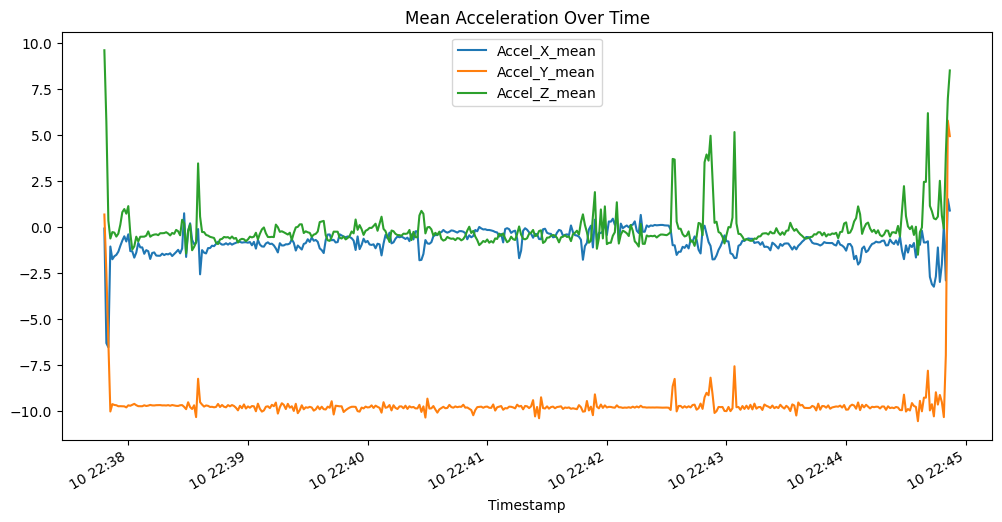

In [9]:
import matplotlib.pyplot as plt

# Plot acceleration mean values over time
combined_data[['Timestamp', 'Accel_X_mean', 'Accel_Y_mean', 'Accel_Z_mean']].plot(x='Timestamp', figsize=(12, 6))
plt.title("Mean Acceleration Over Time")
plt.show()
